#                                                    Projet Big Data

Binome: HOUNA Ayman - SAOUD Yassine.
Lien du dataset: https://www.kaggle.com/datasets/iamsouravbanerjee/heart-attack-prediction-dataset/data

On initialise une session Spark : on configure le nom de l'application comme "Heart attack risk Prediction" et spécifie certaines configurations, telles que le nombre d'instances d'exécution Spark.

In [1]:
import pyspark
from pyspark.sql import SparkSession

import findspark
findspark.init()

spark = SparkSession.builder.appName("Heart attack risk Prediction").config('spark.sql.warehouse.dir', 'file:///random/path/as/we/need/to/config/this/but/dont/use/it').config('spark.executor.instances', 10) .getOrCreate()

On charge ensuite nos données à partir du fichier CSV 'heart_attack_prediction_dataset.csv' dans un DataFrame Spark (df). Les paramètres header=True et inferSchema=True indiquent que la première ligne du fichier contient les noms de colonnes et que le schéma doit être déduit automatiquement.


In [2]:
csvFilePath = 'heart_attack_prediction_dataset.csv'

df = spark.read.csv(csvFilePath, header=True, inferSchema=True)

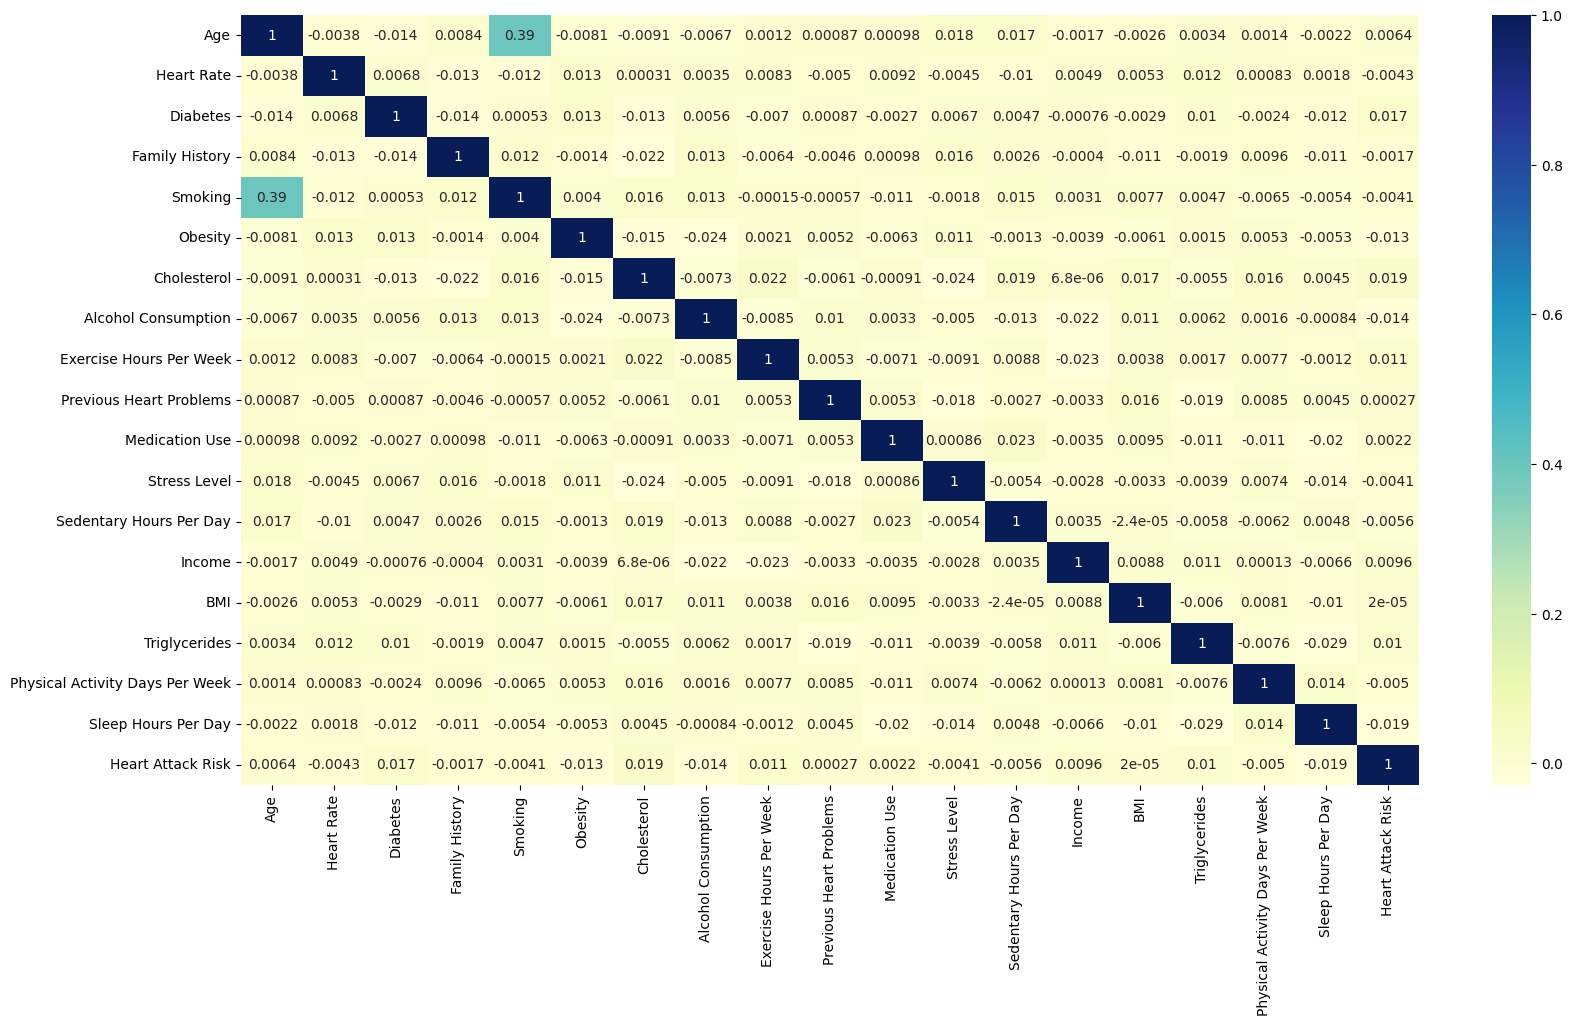

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = ['Age', 'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
                   'Cholesterol', 'Alcohol Consumption', 'Exercise Hours Per Week',
                   'Previous Heart Problems', 'Medication Use', 'Stress Level',
                   'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
                   'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk']

# Calculate the correlation matrix
correlation_matrix = df.select(numeric_columns).toPandas().corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(19, 10))
sns.heatmap(correlation_matrix, cmap="YlGnBu", annot=True)
plt.show()


Impression du schéma du DataFrame (df.printSchema()) pour visualiser la structure des données, puis affichage de la première ligne du DataFrame (df.take(1)) à des fins d'inspection initiale.

In [4]:
df.printSchema()
df.take(1)

root
 |-- Patient ID: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- Blood Pressure: string (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Family History: integer (nullable = true)
 |-- Smoking: integer (nullable = true)
 |-- Obesity: integer (nullable = true)
 |-- Alcohol Consumption: integer (nullable = true)
 |-- Exercise Hours Per Week: double (nullable = true)
 |-- Diet: string (nullable = true)
 |-- Previous Heart Problems: integer (nullable = true)
 |-- Medication Use: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- Sedentary Hours Per Day: double (nullable = true)
 |-- Income: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Triglycerides: integer (nullable = true)
 |-- Physical Activity Days Per Week: integer (nullable = true)
 |-- Sleep Hours Per Day: integer (nullable = true)

[Row(Patient ID='BMW7812', Age=67, Sex='Male', Cholesterol=208, Blood Pressure='158/88', Heart Rate=72, Diabetes=0, Family History=0, Smoking=1, Obesity=0, Alcohol Consumption=0, Exercise Hours Per Week=4.168188835442079, Diet='Average', Previous Heart Problems=0, Medication Use=0, Stress Level=9, Sedentary Hours Per Day=6.6150014529140595, Income=261404, BMI=31.251232725295402, Triglycerides=286, Physical Activity Days Per Week=0, Sleep Hours Per Day=6, Country='Argentina', Continent='South America', Hemisphere='Southern Hemisphere', Heart Attack Risk=0)]

## Data preparation

Identification des colonnes de type 'string' dans le DataFrame et affichage des valeurs uniques pour chacune de ces colonnes.  
Cela aide à comprendre la diversité des catégories dans les colonnes de type chaîne.

In [5]:
from pyspark.sql.functions import col

string_columns = [col_name for col_name, col_type in df.dtypes if col_type == 'string']

for column in string_columns:
    unique_values = df.select(column).distinct().collect()
    unique_values = [row[column] for row in unique_values]
    print(f"Unique values in column '{column}': {unique_values}")


Unique values in column 'Patient ID': ['SDW5368', 'GAD4553', 'VBS9790', 'AJM2459', 'EYQ3522', 'BJD8941', 'RBC9879', 'NYP6875', 'SZO9924', 'YNF8497', 'UWZ7524', 'UZE1032', 'BID1500', 'WWT7514', 'MWT1563', 'NPX0936', 'KVH5292', 'MTP8812', 'QZP5640', 'DCH2386', 'RFI3277', 'SFE3458', 'CVM1144', 'BGZ2161', 'YQE1702', 'DNX1384', 'NSQ1074', 'SJB9226', 'KAT8561', 'HVE8034', 'RQK3939', 'NKY3013', 'WBN7110', 'BGG6399', 'WKL1513', 'TIK9060', 'WKM7418', 'MSI9772', 'CAY7644', 'MJX6940', 'HJN5658', 'EJM1644', 'VHE2099', 'GTT3539', 'SLK1636', 'UPS0402', 'JFC0725', 'MAI0387', 'MAX6504', 'SOT1328', 'TCL3717', 'UMF1713', 'ZBW0154', 'OJX0002', 'MSJ5593', 'XQV3022', 'VYI0256', 'HUJ1013', 'NTG8006', 'WPM0379', 'VMX6534', 'MLU0055', 'LHO0248', 'OUD5407', 'BPX1343', 'WER3064', 'OAQ5995', 'ZTH0478', 'JRZ9303', 'HAH8501', 'DTB1626', 'VMW4677', 'EYW9923', 'KYF8651', 'OQL6643', 'NYJ1422', 'ODK9902', 'XRW7355', 'YET5604', 'RHR5255', 'OKR6669', 'FUM7288', 'QWU3141', 'KDX3222', 'IPX3682', 'HJD8939', 'WKT8901', 'GKB

Division la colonne **"Blood Pressure"** en deux nouvelles colonnes, **"Systolic Blood Pressure"** et **"Diastolic Blood Pressure"**, en utilisant le caractère **'/'** comme séparateur. Les nouvelles colonnes sont converties en type entier, puis la colonne originale "Blood Pressure" est supprimée du DataFrame.

In [6]:
from pyspark.sql.functions import split, col

df = df.withColumn("Systolic Blood Pressure", split(df["Blood Pressure"], "/")[0].cast("int"))
df = df.withColumn("Diastolic Blood Pressure", split(df["Blood Pressure"], "/")[1].cast("int"))
df = df.drop("Blood Pressure")

La colonne **"Sex"** est ensuite encodée en binaire : 1 si le sexe est "Male" et 0 sinon. La nouvelle colonne est **"Sex_binary"**

In [7]:
from pyspark.sql.functions import when

df = df.withColumn("Sex_binary", when(df["Sex"] == "Male", 1).otherwise(0))
df = df.drop("Sex")


De même, une nouvelle colonne **"Diet_encoded"** est créée pour encoder les catégories de régime en valeurs numériques. Les valeurs "Unhealthy" sont codées comme 0, "Average" comme 1, et "Healthy" comme 2. Ensuite, la colonne originale "Diet" est supprimée.

In [8]:

df = df.withColumn("Diet_encoded", when(df["Diet"] == "Unhealthy", 0)
                                 .when(df["Diet"] == "Average", 1)
                                 .when(df["Diet"] == "Healthy", 2)
                                 )
df = df.drop("Diet")

On utilise **StringIndexer** de PySpark pour encoder les colonnes **"Continent"** et **"Country"** en indices numériques. Les nouvelles colonnes résultantes sont renommées en **"ContinentIndex"** et **"CountryIndex"**. Enfin, les colonnes originales "Continent" et "Country" sont supprimées du DataFrame.

In [9]:
from pyspark.ml.feature import StringIndexer

continent_indexer = StringIndexer(inputCol="Continent", outputCol="ContinentIndex")
df = continent_indexer.fit(df).transform(df)
    
country_indexer = StringIndexer(inputCol="Country", outputCol="CountryIndex")
df = country_indexer.fit(df).transform(df)
    
columns_to_drop = ['Continent', 'Country']
df = df.drop(*columns_to_drop)

Une nouvelle colonne **"Hemisphere_binary"** est ajoutée au DataFramede la même manière que **"Sex_binary"**, attribuant la valeur 1 si l'hémisphère est "Northern Hemisphere" et 0 sinon. Ensuite, la colonne originale "Hemisphere" est supprimée.

In [10]:
from pyspark.sql.functions import when


df = df.withColumn("Hemisphere_binary", when(df["Hemisphere"] == "Northern Hemisphere", 1).otherwise(0))
df = df.drop("Hemisphere")

On supprime notre colonne **Patient_ID** car on n'en aura pas besoin pour le traitement et la prédiction.

In [11]:
df = df.drop("Patient ID")

Notre première ligne devient :

In [12]:
df.take(1)

[Row(Age=67, Cholesterol=208, Heart Rate=72, Diabetes=0, Family History=0, Smoking=1, Obesity=0, Alcohol Consumption=0, Exercise Hours Per Week=4.168188835442079, Previous Heart Problems=0, Medication Use=0, Stress Level=9, Sedentary Hours Per Day=6.6150014529140595, Income=261404, BMI=31.251232725295402, Triglycerides=286, Physical Activity Days Per Week=0, Sleep Hours Per Day=6, Heart Attack Risk=0, Systolic Blood Pressure=158, Diastolic Blood Pressure=88, Sex_binary=1, Diet_encoded=1, ContinentIndex=2.0, CountryIndex=1.0, Hemisphere_binary=0)]

On divise le DataFrame en ensembles de données d'entraînement et de test avec des proportions de 80% et 20% respectivement, en utilisant une graine aléatoire de 42 pour la reproductibilité. Les tailles des ensembles d'entraînement et de test sont ensuite affichées pour évaluer la distribution des données.

In [13]:
from pyspark.sql.functions import rand


trainData, testData = df.randomSplit([0.8, 0.2], seed=0)

print("Training set size:", trainData.count())
print("Test set size:", testData.count())

Training set size: 6969
Test set size: 1794


In [14]:
trainData.take(1)

[Row(Age=18, Cholesterol=120, Heart Rate=99, Diabetes=0, Family History=1, Smoking=0, Obesity=1, Alcohol Consumption=1, Exercise Hours Per Week=5.574646576911382, Previous Heart Problems=0, Medication Use=1, Stress Level=10, Sedentary Hours Per Day=7.400341797560836, Income=32612, BMI=34.49088880004861, Triglycerides=184, Physical Activity Days Per Week=2, Sleep Hours Per Day=5, Heart Attack Risk=0, Systolic Blood Pressure=162, Diastolic Blood Pressure=102, Sex_binary=0, Diet_encoded=1, ContinentIndex=0.0, CountryIndex=8.0, Hemisphere_binary=1)]

Les colonnes de nos données sont les suivantes :

In [15]:
trainData.columns

['Age',
 'Cholesterol',
 'Heart Rate',
 'Diabetes',
 'Family History',
 'Smoking',
 'Obesity',
 'Alcohol Consumption',
 'Exercise Hours Per Week',
 'Previous Heart Problems',
 'Medication Use',
 'Stress Level',
 'Sedentary Hours Per Day',
 'Income',
 'BMI',
 'Triglycerides',
 'Physical Activity Days Per Week',
 'Sleep Hours Per Day',
 'Heart Attack Risk',
 'Systolic Blood Pressure',
 'Diastolic Blood Pressure',
 'Sex_binary',
 'Diet_encoded',
 'ContinentIndex',
 'CountryIndex',
 'Hemisphere_binary']

On réorganise l'ordre des colonnes du DataFrame d'entraînement (trainData) en plaçant la colonne "Heart Attack Risk" en premier, suivie des autres colonnes. Cela assure une meilleure lisibilité et organisation des données. La même opération est effectuée pour le DataFrame de test (testData).

In [16]:
new_columns = ['Heart Attack Risk'] + [col for col in trainData.columns if col != 'Heart Attack Risk']
trainData = trainData.select(new_columns)
testData = testData.select(new_columns)

Les colonnes deviennent dans cet ordre :

In [17]:
trainData.columns

['Heart Attack Risk',
 'Age',
 'Cholesterol',
 'Heart Rate',
 'Diabetes',
 'Family History',
 'Smoking',
 'Obesity',
 'Alcohol Consumption',
 'Exercise Hours Per Week',
 'Previous Heart Problems',
 'Medication Use',
 'Stress Level',
 'Sedentary Hours Per Day',
 'Income',
 'BMI',
 'Triglycerides',
 'Physical Activity Days Per Week',
 'Sleep Hours Per Day',
 'Systolic Blood Pressure',
 'Diastolic Blood Pressure',
 'Sex_binary',
 'Diet_encoded',
 'ContinentIndex',
 'CountryIndex',
 'Hemisphere_binary']

In [18]:
trainData.printSchema()

root
 |-- Heart Attack Risk: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Family History: integer (nullable = true)
 |-- Smoking: integer (nullable = true)
 |-- Obesity: integer (nullable = true)
 |-- Alcohol Consumption: integer (nullable = true)
 |-- Exercise Hours Per Week: double (nullable = true)
 |-- Previous Heart Problems: integer (nullable = true)
 |-- Medication Use: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- Sedentary Hours Per Day: double (nullable = true)
 |-- Income: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Triglycerides: integer (nullable = true)
 |-- Physical Activity Days Per Week: integer (nullable = true)
 |-- Sleep Hours Per Day: integer (nullable = true)
 |-- Systolic Blood Pressure: integer (nullable = true)
 |-- Diastolic Blood Pressure: integer (nullable = t

On utilise VectorAssembler de PySpark pour assembler les colonnes d'entités (à l'exclusion de la colonne "Heart Attack Risk") dans les DataFrames d'entraînement (trainData) et de test (testData) en une seule colonne appelée "features". Cela prépare les données pour l'entraînement des modèles.

In [19]:
from pyspark.ml.feature import VectorAssembler

assembler_train = VectorAssembler(
    inputCols=[x for x in trainData.columns[1:]],
    outputCol="features")

assembler_test = VectorAssembler(
    inputCols=[x for x in testData.columns[1:]],
    outputCol="features")

On utilise l'assembleur précédemment défini pour transformer les DataFrames d'entraînement (trainData) et de test (testData) en un format adapté à l'entraînement des modèles. Les colonnes résultantes sont "Heart Attack Risk" (label) et "features" (vecteur de variables)

In [20]:
labeledPointstrain = assembler_train.transform(trainData).select("Heart Attack Risk", "features")
labeledPointstest = assembler_test.transform(testData).select("Heart Attack Risk", "features")

print(labeledPointstrain)

DataFrame[Heart Attack Risk: int, features: vector]


In [21]:
labeledPointstrain.show()

+-----------------+--------------------+
|Heart Attack Risk|            features|
+-----------------+--------------------+
|                0|[18.0,120.0,99.0,...|
|                1|[18.0,123.0,94.0,...|
|                0|[18.0,126.0,71.0,...|
|                0|[18.0,132.0,100.0...|
|                0|[18.0,133.0,51.0,...|
|                0|[18.0,138.0,57.0,...|
|                0|[18.0,143.0,58.0,...|
|                0|[18.0,143.0,80.0,...|
|                0|[18.0,146.0,75.0,...|
|                1|[18.0,147.0,46.0,...|
|                0|[18.0,147.0,95.0,...|
|                1|[18.0,148.0,49.0,...|
|                0|[18.0,148.0,64.0,...|
|                0|[18.0,149.0,86.0,...|
|                0|[18.0,151.0,74.0,...|
|                0|[18.0,154.0,54.0,...|
|                1|[18.0,157.0,85.0,...|
|                0|[18.0,157.0,87.0,...|
|                1|[18.0,159.0,58.0,...|
|                0|[18.0,159.0,83.0,...|
+-----------------+--------------------+
only showing top

## Classification model

In [22]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator


On construit une pipeline avec un classificateur **RandomForest**, qui est ensuite entraîné sur les données d'entraînement. Le modèle entraîné est utilisé pour prédire les risques d'attaque cardiaque sur les ensembles d'entraînement et de test. Les résultats, comprenant la prédiction, la probabilité associée, et les métriques telles que l'exactitude, la F1-score, la précision pondérée et le rappel pondéré, sont affichés pour évaluer la performance du modèle.

L'évaluateur MulticlassClassificationEvaluator est utilisé pour mesurer **la précision**, **la F1-score**, **la précision pondérée** et **le rappel pondéré** du modèle sur l'ensemble de test. Ces métriques offrent une compréhension approfondie de la capacité du modèle à généraliser sur de nouvelles données. 

In [23]:
classifiers = [
    LogisticRegression(labelCol="Heart Attack Risk", featuresCol="features", maxIter=100),
    RandomForestClassifier(labelCol="Heart Attack Risk", featuresCol="features", numTrees=20, maxDepth=15)
]


In [24]:
# creation du pipeline
for classifier in classifiers:
    pipeline = Pipeline(stages=[classifier])
    model = pipeline.fit(labeledPointstrain)
    print(classifier)
    print(classifier.extractParamMap())
    result1 = model.transform(labeledPointstrain)
    result = model.transform(labeledPointstest)

    # Show some prediction results
    result.select("Heart Attack Risk", "prediction", "probability").show()

    evaluator = MulticlassClassificationEvaluator(labelCol="Heart Attack Risk", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(result)
    print(f"Test set accuracy = {accuracy}")

    # Print other evaluation metrics
    evaluator = MulticlassClassificationEvaluator(labelCol="Heart Attack Risk",predictionCol="prediction", metricName="weightedPrecision")
    print("Test set weightedRecall = " + str(evaluator.evaluate(result)))

    evaluator = MulticlassClassificationEvaluator(labelCol="Heart Attack Risk",predictionCol="prediction", metricName="weightedRecall")
    print("Test set weightedPrecision = " + str(evaluator.evaluate(result)))

    evaluator = MulticlassClassificationEvaluator(labelCol="Heart Attack Risk", predictionCol="prediction", metricName="f1")
    f1 = evaluator.evaluate(result)
    print(f"Test set f1 = {f1}")

    label_counts = result.groupBy("Heart Attack Risk").count()
    label_counts.show()
    label_counts = result.groupBy("prediction").count()
    label_counts.show()
    print("_____________________________________________________________________________________________________________")

LogisticRegression_b8f46ab3c0e1
{Param(parent='LogisticRegression_b8f46ab3c0e1', name='maxBlockSizeInMB', doc='maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0.'): 0.0, Param(parent='LogisticRegression_b8f46ab3c0e1', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p].'): 0.5, Param(parent='LogisticRegression_b8f46ab3c0e1', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_b8f46ab3c0e1', name='standardization', doc='whether to standardize the training features before fitting the model.'): True, Param(parent='LogisticRegression_b8f46ab3c0e1', name='fitIn

Le modele logistic regression ne predit aucune valeur positive et n'apporte donc aucune information sur la prediction.
Nous allons donc garder le modele Random Forest Classifier et essayer de l'ameliorer avec un finetuning et cross-validation

In [25]:
classifier = RandomForestClassifier(labelCol="Heart Attack Risk", featuresCol="features", numTrees=20, maxDepth=15)
pipeline = Pipeline(stages=[classifier])
model = pipeline.fit(labeledPointstrain)
result1 = model.transform(labeledPointstrain)
result = model.transform(labeledPointstest)

In [26]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

classifier = RandomForestClassifier(labelCol="Heart Attack Risk", featuresCol="features")
paramGrid = ParamGridBuilder() \
    .addGrid(classifier.numTrees, [10, 15, 20, 30]) \
    .addGrid(classifier.maxDepth, [5, 10, 15, 20]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol="Heart Attack Risk", rawPredictionCol="prediction", metricName="areaUnderROC")

crossval = CrossValidator(estimator=classifier,
                        estimatorParamMaps=paramGrid,
                        evaluator=evaluator,
                        numFolds=5)  # Adjust the number of folds as needed

cvModel = crossval.fit(labeledPointstrain)
bestModel = cvModel.bestModel

print(f"Best model parameters: {bestModel.extractParamMap()}")

Best model parameters: {Param(parent='RandomForestClassifier_d7f717fd9528', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestClassifier_d7f717fd9528', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='RandomForestClassifier_d7f717fd9528', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='RandomForestClassifier_d7f717fd9528', name='featureSubsetStrategy', doc="The number of features to consider for splits at 

Le finetuning montre que le meilleur modele avec numTrees=30 et maxDepth=20 est celui qui a le meilleur score pour Area Under Curve

In [27]:
result_finetuning = bestModel.transform(labeledPointstest)

result_finetuning.select("Heart Attack Risk", "prediction", "probability").show()

evaluator = MulticlassClassificationEvaluator(labelCol="Heart Attack Risk", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(result_finetuning)
print(f"Test set accuracy = {accuracy}")

evaluator = MulticlassClassificationEvaluator(labelCol="Heart Attack Risk", predictionCol="prediction", metricName="f1")
f1 = evaluator.evaluate(result_finetuning)
print(f"Test set f1 = {f1}")

evaluator = MulticlassClassificationEvaluator(labelCol="Heart Attack Risk",predictionCol="prediction", metricName="weightedPrecision")
print("Test set weightedPrecision = " + str(evaluator.evaluate(result_finetuning)))

evaluator = MulticlassClassificationEvaluator(labelCol="Heart Attack Risk",predictionCol="prediction", metricName="weightedRecall")
print("Test set weightedRecall = " + str(evaluator.evaluate(result_finetuning)))

evaluator = BinaryClassificationEvaluator(labelCol="Heart Attack Risk", rawPredictionCol="prediction", metricName="areaUnderROC")
print("Test set AreaUnderROC = " + str(evaluator.evaluate(result_finetuning)))
print("_____________________________________________________________________________________________________________")

+-----------------+----------+--------------------+
|Heart Attack Risk|prediction|         probability|
+-----------------+----------+--------------------+
|                0|       0.0|[0.59285714285714...|
|                1|       0.0|[0.65533333333333...|
|                0|       0.0|[0.71153846153846...|
|                0|       0.0|[0.79034269755993...|
|                0|       0.0|[0.67012195121951...|
|                0|       0.0|     [0.7125,0.2875]|
|                1|       0.0|[0.59446503840538...|
|                1|       0.0|[0.57172699192143...|
|                1|       1.0|[0.48300684079601...|
|                1|       0.0|[0.82351778656126...|
|                0|       1.0|[0.23652986590816...|
|                0|       0.0|[0.51686274509803...|
|                0|       0.0|[0.70491389207807...|
|                0|       1.0|[0.48224731182795...|
|                1|       0.0|[0.95800865800865...|
|                1|       0.0|         [0.55,0.45]|
|           

In [28]:
label_counts = result.groupBy("Heart Attack Risk").count()
label_counts.show()
label_counts = result.groupBy("prediction").count()
label_counts.show()

+-----------------+-----+
|Heart Attack Risk|count|
+-----------------+-----+
|                1|  637|
|                0| 1157|
+-----------------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 1570|
|       1.0|  224|
+----------+-----+



In [29]:
label_counts = result_finetuning.groupBy("Heart Attack Risk").count()
label_counts.show()
label_counts = result_finetuning.groupBy("prediction").count()
label_counts.show()

+-----------------+-----+
|Heart Attack Risk|count|
+-----------------+-----+
|                1|  637|
|                0| 1157|
+-----------------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 1457|
|       1.0|  337|
+----------+-----+



In [30]:
spark.stop()